# Gesture Recognition

By

    Sandhya Girish
    Sreevalli Karanam

## Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognize five different gestures performed by the user which will help users control the TV without using a remote. The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

    •	Thumbs up: Increase the volume
    •	Thumbs down: Decrease the volume
    •	Left swipe: 'Jump' backwards 10 seconds
    •	Right swipe: 'Jump' forward 10 seconds
    •	Stop: Pause the movie

Each video is a sequence of 30 frames (or images)

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

### Objectives:

<b>Generator:</b> The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

<b>Model:</b> Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

<b>Write up:</b> This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
#Importing Libraries
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32 #While modelling did experiments with different batch sizes below

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator,  preprocessed the images as we have images of 2 different dimensions sich ad resized the images, Normalized the images as well as create a batch of video frames. 

In [4]:
def generator(source_path, folder_list, batch_size,image_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,16)).astype(int) #Passing alternate frames
    #img_idx = np.round(np.linspace(0,29,20)).astype(int) # Passing 20 frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
          batch_data, batch_labels= getBatchData(batch,batch_size,img_idx,source_path,t,image_size)
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # code for the remaining data points which are left after full batches

        if len(t)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(t)%batch_size
            batch_data, batch_labels= getBatchData(num_batches,batch_size,img_idx,source_path,t,image_size)
            yield batch_data, batch_labels
        
       



def getBatchData(batch,batch_size,img_idx,source_path,t,image_size):
  batch_data = np.zeros((batch_size,len(img_idx),image_size,image_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
  batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
  for folder in range(batch_size): # iterate over the batch_size
    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
      image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
      #crop the images and resize them. Note that the images are of 2 different shape 
      #and the conv3D will throw error if the inputs in a batch have different shapes
      image_resized=resize(image,(image_size,image_size,3))

      batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255.0
      batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255.0
      batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255.0
                    
    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
  return batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


In [6]:
# Validating generator function by checking with training and validation folders
# For testing the generator sending image size parameter value as 100 and batch size as 32 to generator function
image_size=100
batch_size = 32
sample_generator = generator(train_path, train_doc, batch_size,image_size)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size,image_size)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /home/datasets/Project_data/train ; batch size = 32
(32, 16, 100, 100, 3)
Source path =  /home/datasets/Project_data/val ; batch size = 32
(32, 16, 100, 100, 3)


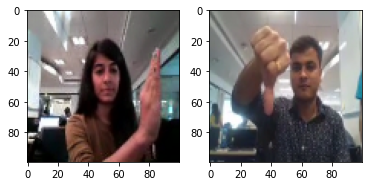

In [13]:
#plotting images from Validation data
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[16,10,:,:,:])   
ax[1].imshow(sample_val_batch_data[25,10,:,:,:])
plt.show()

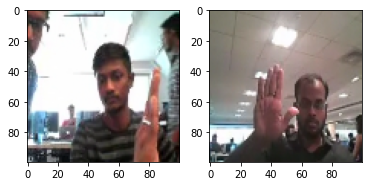

In [14]:
#Plotting images from Training data
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_batch_data[10,10,:,:,:])   
ax[1].imshow(sample_batch_data[25,10,:,:,:])
plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D , Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers


In [8]:
def model_train(model,batch_size,image_size):

  #Let us create the train_generator and the val_generator which will be used in .fit_generator.
  train_generator = generator(train_path, train_doc, batch_size,image_size)
  val_generator = generator(val_path, val_doc, batch_size,image_size)

  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
  if not os.path.exists(model_name):
    os.mkdir(model_name)
  
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
  earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
  callbacks_list = [checkpoint,LR, earlystop]


  #The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = (num_val_sequences//batch_size) + 1

  #Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
  return history


#### Models using Conv3D and MaxPooling3D architecture

In [18]:
#Model1
#model1_batch_size = 32
#model1_image_size=100

#model1 = Sequential()
#model1.add(Conv3D(16, kernel_size=3, padding='same',activation='relu',input_shape=(20,100,100,3)))
#model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model1.add(Conv3D(32, kernel_size=3, padding='same',activation='relu'))
#model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model1.add(Conv3D(64, kernel_size=3, padding='same',activation='relu'))
#model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model1.add(Conv3D(128, kernel_size=3, padding='same',activation='relu'))
#model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model1.add(Flatten())
#model1.add(Dense(128,activation='relu'))
#model1.add(Dense(128,activation='relu'))
#model1.add(Dense(5,activation='softmax'))

#Now that you have written the model, the next step is to compile the model. 
#When you print the summary of the model, you'll see the total number of parameters you have to train.
#optimiser = tf.optimizers.Adam()
#model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 50, 50, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 25, 25, 32)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 5, 25, 25, 64)     55360     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 2, 12, 12, 64)   

In [19]:
#Train the model

#model1_history=model_train(model1,model1_batch_size,model1_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6056 - categorical_accuracy: 0.2127Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.59443, saving model to model_init_2022-06-0914_09_28.447198/model-00001-1.60556-0.21267-1.59443-0.26000.h5
21/21 [==============================] - 99s 5s/step - loss: 1.6056 - categorical_accuracy: 0.2127 - val_loss: 1.5944 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.5084 - categorical_accuracy: 0.2899
Epoch 00002: val_loss improved from 1.59443 to 1.42441, saving model to model_init_2022-06-0914_09_28.447198/model-00002-1.50836-0.28986-1.42441-0.25000.h5
21/21 [==============================] - 63s 3s/step - loss: 1.5084 - categorical_accuracy: 0.2899 - val_loss: 1.4244 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
21/21

In [9]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss / Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy / Validation accuracy")
    plt.show()


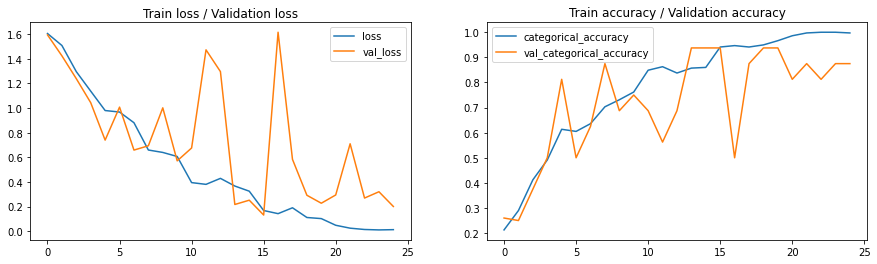

In [20]:
#plotModelHistory(model1_history)

Model1 with batch size 32 , number of frames used is 20. 
Difference between training and validation accuracy is more

In [13]:
#Model2 With dropouts
#model2_batch_size = 32
#model2_image_size=100

#model2 = Sequential()
#model2.add(Conv3D(16, kernel_size=3, padding='same',activation='relu',input_shape=(20,100,100,3)))
#model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model2.add(Conv3D(32, kernel_size=3, padding='same',activation='relu'))
#model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model2.add(Dropout(0.2))
#model2.add(Conv3D(64, kernel_size=3, padding='same',activation='relu'))
#model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model2.add(Conv3D(128, kernel_size=3, padding='same',activation='relu'))
#model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model2.add(Dropout(0.2))
#model2.add(Flatten())
#model2.add(Dense(128,activation='relu'))
#model2.add(Dense(128,activation='relu'))
#model2.add(Dropout(0.2))
#model2.add(Dense(5,activation='softmax'))

#Now that you have written the model, the next step is to compile the model. 
#When you print the summary of the model, you'll see the total number of parameters you have to train.
#optimiser = tf.optimizers.Adam()
#model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 50, 50, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 5, 25, 25, 32)    0         
 3D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 25, 25, 32)     0         
                                                                 
 conv3d_6 (Conv3D)           (None, 5, 25, 25, 64)    

In [14]:
#model2_history=model_train(model2,model2_batch_size,model2_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6066 - categorical_accuracy: 0.2036Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.52704, saving model to model_init_2022-06-0903_36_00.787126/model-00001-1.60659-0.20362-1.52704-0.24000.h5
21/21 [==============================] - 103s 5s/step - loss: 1.6066 - categorical_accuracy: 0.2036 - val_loss: 1.5270 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.4974 - categorical_accuracy: 0.2961
Epoch 00002: val_loss improved from 1.52704 to 1.36951, saving model to model_init_2022-06-0903_36_00.787126/model-00002-1.49741-0.29607-1.36951-0.31250.h5
21/21 [==============================] - 66s 3s/step - loss: 1.4974 - categorical_accuracy: 0.2961 - val_loss: 1.3695 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 3/25
21/2

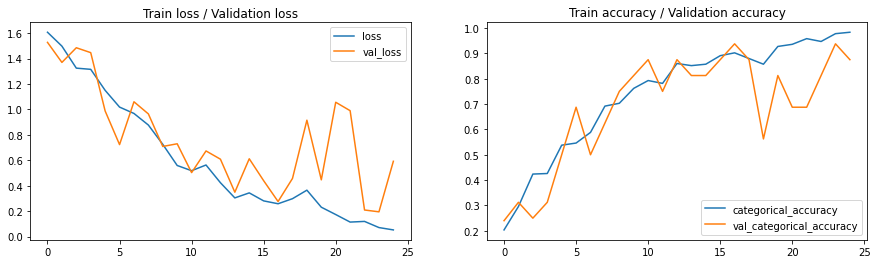

In [15]:
#plotModelHistory(model2_history)

Model1 with batch size 32 , number of frames used is 20.Dropous has been added.
Difference between training and validation accuracy is more.

In [16]:
# Model3 With BatchNormalization and droputs
#model3_batch_size = 32 
#model3_image_size=100

#model3 = Sequential()
#model3.add(Conv3D(16, kernel_size=3, padding='same',activation='relu',input_shape=(20,100,100,3)))
#model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model3.add(Conv3D(32, kernel_size=3, padding='same',activation='relu'))
#model3.add(BatchNormalization())
#model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model3.add(Dropout(0.2))
#model3.add(Conv3D(64, kernel_size=3, padding='same',activation='relu'))
#model3.add(BatchNormalization())
#model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model3.add(Conv3D(128, kernel_size=3, padding='same',activation='relu'))
#model3.add(BatchNormalization())
#model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model3.add(Dropout(0.2))
#model3.add(Flatten())
#model3.add(Dense(128,activation='relu'))
#model3.add(Dense(128,activation='relu'))
#model3.add(Dropout(0.2))
#model3.add(Dense(5,activation='softmax'))

#Now that you have written the model, the next step is to compile the model. 
#When you print the summary of the model, you'll see the total number of parameters you have to train.
#optimiser = tf.optimizers.Adam()
#model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 50, 50, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 50, 50, 32)    13856     
                                                                 
 batch_normalization (BatchN  (None, 10, 50, 50, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 25, 25, 32)    0         
 3D)                                                             
                                                      

In [17]:
#model3_history=model_train(model3,model3_batch_size,model3_image_size )

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 2.1707 - categorical_accuracy: 0.3333Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 2.15007, saving model to model_init_2022-06-0903_36_00.787126/model-00001-2.17073-0.33333-2.15007-0.18000.h5
21/21 [==============================] - 104s 5s/step - loss: 2.1707 - categorical_accuracy: 0.3333 - val_loss: 2.1501 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.3314 - categorical_accuracy: 0.4327
Epoch 00002: val_loss improved from 2.15007 to 1.85359, saving model to model_init_2022-06-0903_36_00.787126/model-00002-1.33139-0.43271-1.85359-0.18750.h5
21/21 [==============================] - 65s 3s/step - loss: 1.3314 - categorical_accuracy: 0.4327 - val_loss: 1.8536 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/25
21/2

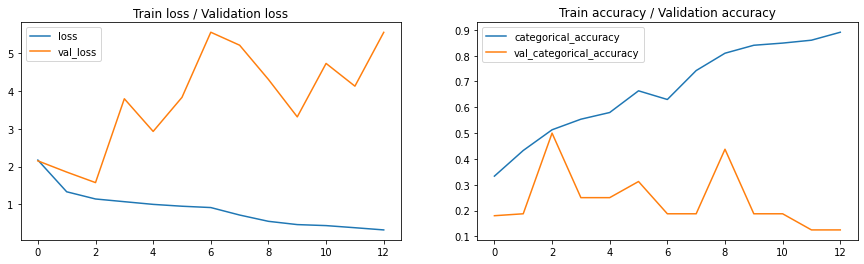

In [18]:
#plotModelHistory(model3_history)

Model3 with batch size 32 , number of frames used is 20.Batch Normalization and droputs layers were added.
Validation accuracy is very low and is getting decreased with each epoch. So training has stopped after 13 epochs due to earlystop. Its overfitting

In [19]:
#Model4 with number of batches 64
#model4_batch_size=64
#model4_image_size=100

#model4 = Sequential()
#model4.add(Conv3D(16, kernel_size=3, padding='same',activation='relu',input_shape=(20,100,100,3)))
#model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model4.add(Conv3D(32, kernel_size=3, padding='same',activation='relu'))
#model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model4.add(Conv3D(64, kernel_size=3, padding='same',activation='relu'))
#model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model4.add(Conv3D(128, kernel_size=3, padding='same',activation='relu'))
#model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model4.add(Flatten())
#model4.add(Dense(128,activation='relu'))
#model4.add(Dense(128,activation='relu'))
#model4.add(Dense(5,activation='softmax'))

#Now that you have written the model, the next step is to compile the model. 
#When you print the summary of the model, you'll see the total number of parameters you have to train.
#optimiser = tf.optimizers.Adam()
#model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 5, 25, 25, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 5, 25, 25, 64)     55360     
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 2, 12, 12, 64)   

In [20]:
#model4_history=model_train(model4,model4_batch_size,model4_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.6016 - categorical_accuracy: 0.2097Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 1.53229, saving model to model_init_2022-06-0903_36_00.787126/model-00001-1.60162-0.20965-1.53229-0.22000.h5
11/11 [==============================] - 105s 10s/step - loss: 1.6016 - categorical_accuracy: 0.2097 - val_loss: 1.5323 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.5207 - categorical_accuracy: 0.2806
Epoch 00002: val_loss improved from 1.53229 to 1.44871, saving model to model_init_2022-06-0903_36_00.787126/model-00002-1.52070-0.28063-1.44871-0.35938.h5
11/11 [==============================] - 47s 5s/step - loss: 1.5207 - categorical_accuracy: 0.2806 - val_loss: 1.4487 - val_categorical_accuracy: 0.3594 - lr: 0.0010
Epoch 3/25
11/

Model4 with batch size 64, Image size 100 and difference between accuracies is high

In [21]:
#Model 5 with Batch size 64, Output shapes(120,120)
#model5_batch_size = 64 
#model5_image_size=120

#model5 = Sequential()
#model5.add(Conv3D(16, kernel_size=3, padding='same',activation='relu',input_shape=(20,120,120,3)))
#model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model5.add(Conv3D(32, kernel_size=3, padding='same',activation='relu'))
#model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model5.add(Dropout(0.2))
#model5.add(Conv3D(64, kernel_size=3, padding='same',activation='relu'))
#model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model5.add(Conv3D(128, kernel_size=3, padding='same',activation='relu'))
#model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model5.add(Dropout(0.2))
#model5.add(Flatten())
#model5.add(Dense(128,activation='relu'))
#model5.add(Dense(128,activation='relu'))
#model5.add(Dense(5,activation='softmax'))

#Now that you have written the model, the next step is to compile the model. 
#When you print the summary of the model, you'll see the total number of parameters you have to train.
#optimiser = tf.optimizers.Adam()
#model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 5, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 5, 30, 30, 32)     0         
                                                                 
 conv3d_18 (Conv3D)          (None, 5, 30, 30, 64)    

In [22]:
#model5_history=model_train(model5,model5_batch_size,model5_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.6364 - categorical_accuracy: 0.1870Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 1.60551, saving model to model_init_2022-06-0903_36_00.787126/model-00001-1.63635-0.18703-1.60551-0.14000.h5
11/11 [==============================] - 108s 10s/step - loss: 1.6364 - categorical_accuracy: 0.1870 - val_loss: 1.6055 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.6047 - categorical_accuracy: 0.1976
Epoch 00002: val_loss improved from 1.60551 to 1.57452, saving model to model_init_2022-06-0903_36_00.787126/model-00002-1.60472-0.19763-1.57452-0.15625.h5
11/11 [==============================] - 45s 4s/step - loss: 1.6047 - categorical_accuracy: 0.1976 - val_loss: 1.5745 - val_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 3/25
11/

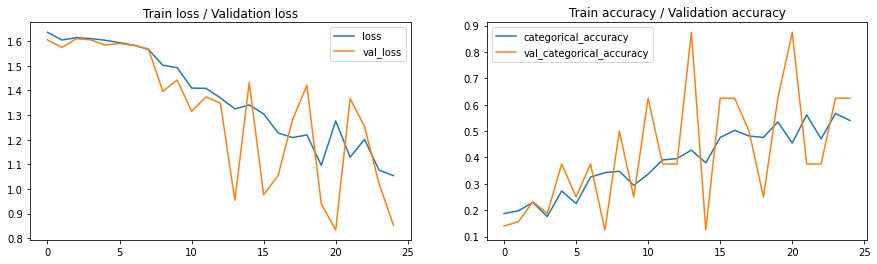

In [23]:
#plotModelHistory(model5_history)

Model5 with batch size 64, Image size 100. Accuracies are very low with just 60%

In [29]:
#Model 6 with Batch size 64, Output shapes(80,80)

#model6_batch_size = 64 
#model6_image_size=80

#model6 = Sequential()
#model6.add(Conv3D(16, kernel_size=3, padding='same',activation='relu',input_shape=(20,80,80,3)))
#model6.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model6.add(Conv3D(32, kernel_size=3, padding='same',activation='relu'))
#model6.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model6.add(Dropout(0.2))
#model6.add(Conv3D(64, kernel_size=3, padding='same',activation='relu'))
#model6.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model6.add(Conv3D(128, kernel_size=3, padding='same',activation='relu'))
#model6.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model6.add(Dropout(0.2))
#model6.add(Flatten())
#model6.add(Dense(128,activation='relu'))
#model6.add(Dense(128,activation='relu'))
#model6.add(Dense(5,activation='softmax'))

#Now that you have written the model, the next step is to compile the model. 
#When you print the summary of the model, you'll see the total number of parameters you have to train.
#optimiser = tf.optimizers.Adam()
#model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model6.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 20, 80, 80, 16)    1312      
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 10, 40, 40, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 10, 40, 40, 32)    13856     
                                                                 
 max_pooling3d_33 (MaxPoolin  (None, 5, 20, 20, 32)    0         
 g3D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 5, 20, 20, 32)     0         
                                                                 
 conv3d_34 (Conv3D)          (None, 5, 20, 20, 64)    

In [30]:
#model6_history=model_train(model6,model6_batch_size,model6_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.6103 - categorical_accuracy: 0.2051Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 1.60613, saving model to model_init_2022-06-0903_36_00.787126/model-00001-1.61029-0.20513-1.60613-0.17000.h5
11/11 [==============================] - 105s 10s/step - loss: 1.6103 - categorical_accuracy: 0.2051 - val_loss: 1.6061 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.5382 - categorical_accuracy: 0.2530
Epoch 00002: val_loss improved from 1.60613 to 1.59750, saving model to model_init_2022-06-0903_36_00.787126/model-00002-1.53817-0.25296-1.59750-0.20312.h5
11/11 [==============================] - 46s 5s/step - loss: 1.5382 - categorical_accuracy: 0.2530 - val_loss: 1.5975 - val_categorical_accuracy: 0.2031 - lr: 0.0010
Epoch 3/25
11/

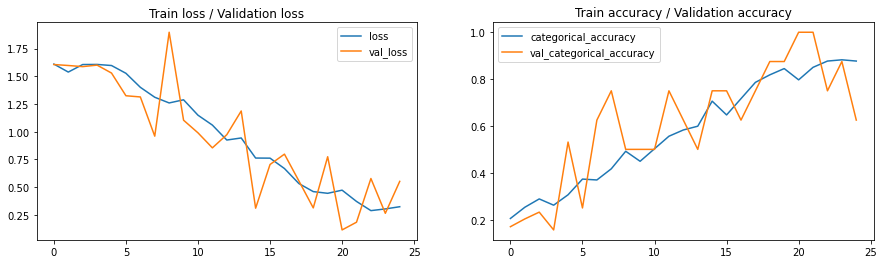

In [31]:
#plotModelHistory(model6_history)

Model6 with batch size 64, Image size 80 and its kind of overfitting model as there is huge difference between training accuracy and Validation accuracy

In [16]:
#Model 7 with Batch size 64, Output shapes(80,80) and changing the dense layer to 64 and number frames took are 16 (alternate frames)

model7_batch_size = 64 
model7_image_size=80

model7 = Sequential()
model7.add(Conv3D(16, kernel_size=3, padding='same',activation='relu',input_shape=(16,80,80,3)))
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model7.add(Conv3D(32, kernel_size=3, padding='same',activation='relu'))
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))
model7.add(Dropout(0.2))
model7.add(Conv3D(64, kernel_size=3, padding='same',activation='relu'))
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model7.add(Conv3D(128, kernel_size=3, padding='same',activation='relu'))
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))
model7.add(Dropout(0.2))
model7.add(Flatten())
model7.add(Dense(64,activation='relu'))
model7.add(Dense(64,activation='relu'))
model7.add(Dense(5,activation='softmax'))

#Now that you have written the model, the next step is to compile the model. 
#When you print the summary of the model, you'll see the total number of parameters you have to train.
optimiser = tf.optimizers.Adam()
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_19 (Conv3D)          (None, 16, 80, 80, 16)    1312      
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 8, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_20 (Conv3D)          (None, 8, 40, 40, 32)     13856     
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 4, 20, 20, 32)    0         
 g3D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 4, 20, 20, 32)     0         
                                                                 
 conv3d_21 (Conv3D)          (None, 4, 20, 20, 64)    

In [17]:
#model7_history=model_train(model7,model7_batch_size,model7_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.6074 - categorical_accuracy: 0.2127Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 1.56859, saving model to model_init_2022-06-1002_30_45.054356/model-00001-1.60736-0.21267-1.56859-0.19000.h5
11/11 [==============================] - 81s 8s/step - loss: 1.6074 - categorical_accuracy: 0.2127 - val_loss: 1.5686 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.5416 - categorical_accuracy: 0.2806
Epoch 00002: val_loss improved from 1.56859 to 1.48492, saving model to model_init_2022-06-1002_30_45.054356/model-00002-1.54161-0.28063-1.48492-0.20312.h5
11/11 [==============================] - 37s 4s/step - loss: 1.5416 - categorical_accuracy: 0.2806 - val_loss: 1.4849 - val_categorical_accuracy: 0.2031 - lr: 0.0010
Epoch 3/25
11/11

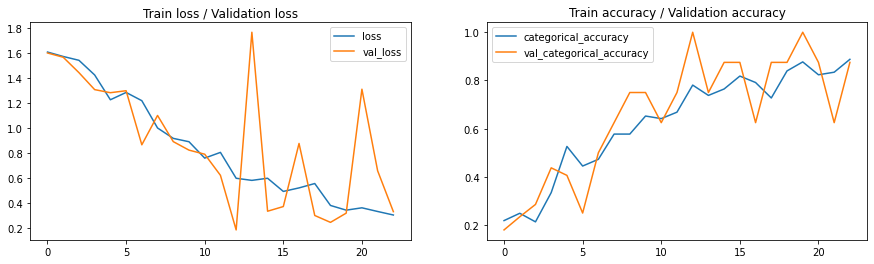

In [34]:
#plotModelHistory(model7_history)

Model 7 with Batch size 64, Output shapes(80,80) and changing the dense layer to 64 and number frames took are 16 (alternate frames). Difference bwetween accuracies is high.

In [42]:
#Model 8 with Batch size 32, Output shapes(80,80) and changing the dense layer to 64

model8_batch_size = 32 
model8_image_size=80

model8 = Sequential()
model8.add(Conv3D(16, kernel_size=3, padding='same',activation='relu',input_shape=(16,80,80,3)))
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8.add(Conv3D(32, kernel_size=3, padding='same',activation='relu'))
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))
model8.add(Dropout(0.2))
model8.add(Conv3D(64, kernel_size=3, padding='same',activation='relu'))
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8.add(Conv3D(128, kernel_size=3, padding='same',activation='relu'))
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))
model8.add(Dropout(0.2))
model8.add(Flatten())
model8.add(Dense(64,activation='relu'))
model8.add(Dense(64,activation='relu'))
model8.add(Dense(5,activation='softmax'))

#Now that you have written the model, the next step is to compile the model. 
#When you print the summary of the model, you'll see the total number of parameters you have to train.
optimiser = tf.optimizers.Adam()
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_63 (Conv3D)          (None, 16, 80, 80, 16)    1312      
                                                                 
 max_pooling3d_63 (MaxPoolin  (None, 8, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_64 (Conv3D)          (None, 8, 40, 40, 32)     13856     
                                                                 
 max_pooling3d_64 (MaxPoolin  (None, 4, 20, 20, 32)    0         
 g3D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 4, 20, 20, 32)     0         
                                                                 
 conv3d_65 (Conv3D)          (None, 4, 20, 20, 64)   

In [43]:
model8_history=model_train(model8,model8_batch_size,model8_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6080 - categorical_accuracy: 0.2006Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.55627, saving model to model_init_2022-06-1002_30_45.054356/model-00001-1.60805-0.20060-1.55627-0.23000.h5
21/21 [==============================] - 100s 5s/step - loss: 1.6080 - categorical_accuracy: 0.2006 - val_loss: 1.5563 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.5050 - categorical_accuracy: 0.2547
Epoch 00002: val_loss improved from 1.55627 to 1.43735, saving model to model_init_2022-06-1002_30_45.054356/model-00002-1.50500-0.25466-1.43735-0.37500.h5
21/21 [==============================] - 66s 3s/step - loss: 1.5050 - categorical_accuracy: 0.2547 - val_loss: 1.4374 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 3/25
21/2

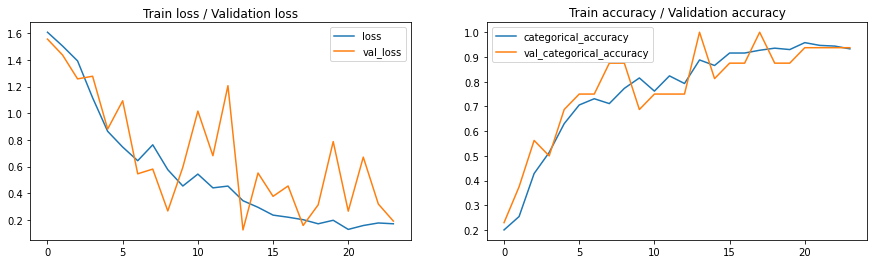

In [44]:
plotModelHistory(model8_history)

Model 8 with Batch size 32, Output shapes(80,80) and changing the dense layer to 64 and number frames took are 16 (alternate frames). 
Accuracy is good and difference between training and validation accuracies is very low which means model performs very well withis data.We will consider this model

In [20]:
#Model 9 with Batch size 32 and Output shapes(100,100) and changing the dense layer to 64

model9_batch_size = 32 
model9_image_size=100

model9 = Sequential()
model9.add(Conv3D(16, kernel_size=3, padding='same',activation='relu',input_shape=(16,100,100,3)))
model9.add(MaxPooling3D(pool_size=(2, 2, 2)))

model9.add(Conv3D(32, kernel_size=3, padding='same',activation='relu'))
model9.add(MaxPooling3D(pool_size=(2, 2, 2)))
model9.add(Dropout(0.2))
model9.add(Conv3D(64, kernel_size=3, padding='same',activation='relu'))
model9.add(MaxPooling3D(pool_size=(2, 2, 2)))

model9.add(Conv3D(128, kernel_size=3, padding='same',activation='relu'))
model9.add(MaxPooling3D(pool_size=(2, 2, 2)))
model9.add(Dropout(0.2))
model9.add(Flatten())
model9.add(Dense(64,activation='relu'))
model9.add(Dense(64,activation='relu'))
model9.add(Dropout(0.2))
model9.add(Dense(5,activation='softmax'))

#Now that you have written the model, the next step is to compile the model. 
#When you print the summary of the model, you'll see the total number of parameters you have to train.
optimiser = tf.optimizers.Adam()
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model9.summary())


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_27 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_28 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 4, 25, 25, 32)    0         
 g3D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 4, 25, 25, 32)     0         
                                                                 
 conv3d_29 (Conv3D)          (None, 4, 25, 25, 64)    

In [21]:
model9_history=model_train(model9,model9_batch_size,model9_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.5965 - categorical_accuracy: 0.2036Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.51910, saving model to model_init_2022-06-1002_30_45.054356/model-00001-1.59649-0.20362-1.51910-0.25000.h5
21/21 [==============================] - 84s 4s/step - loss: 1.5965 - categorical_accuracy: 0.2036 - val_loss: 1.5191 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.4872 - categorical_accuracy: 0.3043
Epoch 00002: val_loss improved from 1.51910 to 1.22480, saving model to model_init_2022-06-1002_30_45.054356/model-00002-1.48717-0.30435-1.22480-0.31250.h5
21/21 [==============================] - 53s 3s/step - loss: 1.4872 - categorical_accuracy: 0.3043 - val_loss: 1.2248 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 3/25
21/21

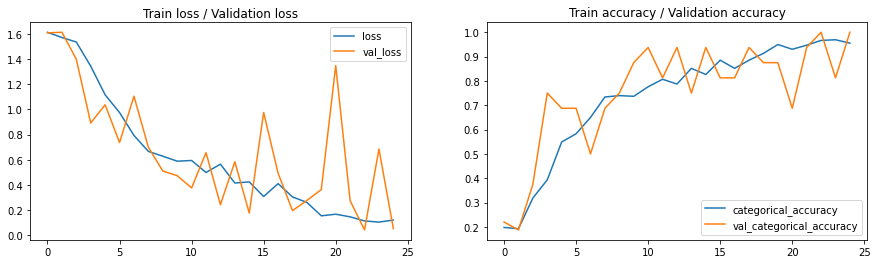

In [12]:
plotModelHistory(model9_history)

Training Accuracy is good but differene between training and Validation accuracy is high which leads to overfitting

In [22]:
#Model 10 with Batch size 128, Output shapes(80,80)
#So far Model8 looks good with less number of paramters. So using the same architecture but increasing the batch size to 128
model10_batch_size = 128
model10_image_size=80

model10 = Sequential()
model10.add(Conv3D(16, kernel_size=3, padding='same',activation='relu',input_shape=(16,80,80,3)))
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model10.add(Conv3D(32, kernel_size=3, padding='same',activation='relu'))
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))
model10.add(Dropout(0.2))
model10.add(Conv3D(64, kernel_size=3, padding='same',activation='relu'))
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model10.add(Conv3D(128, kernel_size=3, padding='same',activation='relu'))
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))
model10.add(Dropout(0.2))
model10.add(Flatten())
model10.add(Dense(64,activation='relu'))
model10.add(Dense(64,activation='relu'))
model10.add(Dense(5,activation='softmax'))

#Now that you have written the model, the next step is to compile the model. 
#When you print the summary of the model, you'll see the total number of parameters you have to train.
optimiser = tf.optimizers.Adam()
model10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model10.summary())


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_31 (Conv3D)          (None, 16, 80, 80, 16)    1312      
                                                                 
 max_pooling3d_31 (MaxPoolin  (None, 8, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_32 (Conv3D)          (None, 8, 40, 40, 32)     13856     
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 4, 20, 20, 32)    0         
 g3D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 4, 20, 20, 32)     0         
                                                                 
 conv3d_33 (Conv3D)          (None, 4, 20, 20, 64)    

In [23]:
model10_history=model_train(model10,model10_batch_size,model10_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 128
Epoch 1/25
6/6 [==============================] - ETA: 0s - loss: 1.6152 - categorical_accuracy: 0.1825 Source path =  /home/datasets/Project_data/val ; batch size = 128

Epoch 00001: val_loss improved from inf to 1.60269, saving model to model_init_2022-06-1002_30_45.054356/model-00001-1.61521-0.18250-1.60269-0.25000.h5
6/6 [==============================] - 86s 17s/step - loss: 1.6152 - categorical_accuracy: 0.1825 - val_loss: 1.6027 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
6/6 [==============================] - ETA: 0s - loss: 1.5808 - categorical_accuracy: 0.2536
Epoch 00002: val_loss did not improve from 1.60269
6/6 [==============================] - 39s 8s/step - loss: 1.5808 - categorical_accuracy: 0.2536 - val_loss: 1.6158 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
6/6 [==============================] - ETA: 0s - loss: 1.6030 - categorical_accuracy: 0.2246
Epoch 00003: val_loss

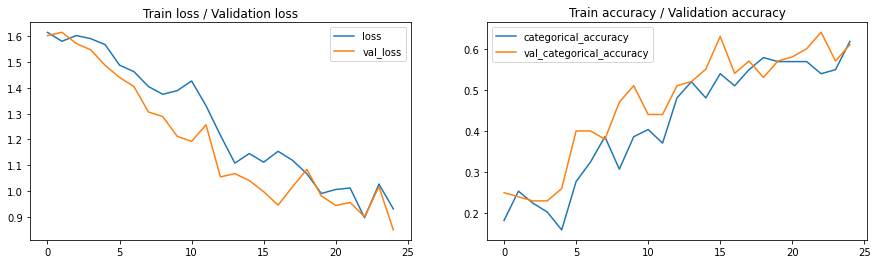

In [25]:
plotModelHistory(model10_history)

Increased the batch size to 128 but accuracies are good with batch size 32 so not using this model.After 25 epochs accuracy is low

In [29]:
#Model 11 with Batch size 256, Output shapes(80,80)
#So far Model8 looks good with less number of paramters. So using the same architecture but increasing the batch size to 256
model11_batch_size = 256
model11_image_size=80

model11 = Sequential()
model11.add(Conv3D(16, kernel_size=3, padding='same',activation='relu',input_shape=(16,80,80,3)))
model11.add(MaxPooling3D(pool_size=(2, 2, 2)))

model11.add(Conv3D(32, kernel_size=3, padding='same',activation='relu'))
model11.add(MaxPooling3D(pool_size=(2, 2, 2)))
model11.add(Dropout(0.2))
model11.add(Conv3D(64, kernel_size=3, padding='same',activation='relu'))
model11.add(MaxPooling3D(pool_size=(2, 2, 2)))

model11.add(Conv3D(128, kernel_size=3, padding='same',activation='relu'))
model11.add(MaxPooling3D(pool_size=(2, 2, 2)))
model11.add(Dropout(0.2))
model11.add(Flatten())
model11.add(Dense(64,activation='relu'))
model11.add(Dense(64,activation='relu'))
model11.add(Dense(5,activation='softmax'))

#Now that you have written the model, the next step is to compile the model. 
#When you print the summary of the model, you'll see the total number of parameters you have to train.
optimiser = tf.optimizers.Adam()
model11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model11.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_43 (Conv3D)          (None, 16, 80, 80, 16)    1312      
                                                                 
 max_pooling3d_43 (MaxPoolin  (None, 8, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_44 (Conv3D)          (None, 8, 40, 40, 32)     13856     
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 4, 20, 20, 32)    0         
 g3D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 4, 20, 20, 32)     0         
                                                                 
 conv3d_45 (Conv3D)          (None, 4, 20, 20, 64)   

In [30]:
model11_history=model_train(model11,model11_batch_size,model11_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 256
Epoch 1/25
3/3 [==============================] - ETA: 0s - loss: 1.6193 - categorical_accuracy: 0.1961 Source path =  /home/datasets/Project_data/val ; batch size = 256

Epoch 00001: val_loss improved from inf to 1.59595, saving model to model_init_2022-06-1002_30_45.054356/model-00001-1.61934-0.19608-1.59595-0.17000.h5
3/3 [==============================] - 76s 37s/step - loss: 1.6193 - categorical_accuracy: 0.1961 - val_loss: 1.5960 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
3/3 [==============================] - ETA: 0s - loss: 1.6055 - categorical_accuracy: 0.1810 
Epoch 00002: val_loss did not improve from 1.59595
3/3 [==============================] - 61s 30s/step - loss: 1.6055 - categorical_accuracy: 0.1810 - val_loss: 1.5987 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
3/3 [==============================] - ETA: 0s - loss: 1.5966 - categorical_accuracy: 0.2007
Epoch 00003: val_lo

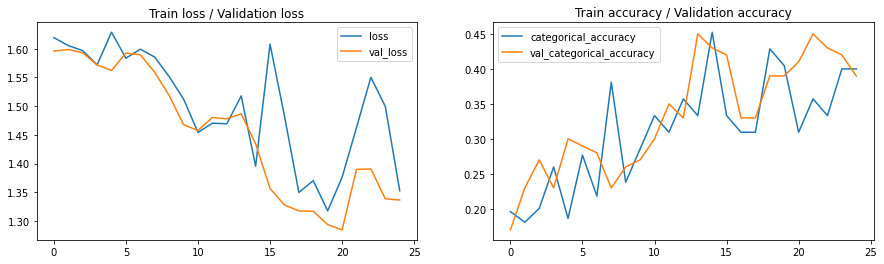

In [31]:
plotModelHistory(model11_history)

Increased the batch size to 256 but accuracies are good with batch size 32 so not using this model.After 25 epochs accuracy is low

In [32]:
#Model 12 with Batch size 512, Output shapes(80,80) 
#So far Model8 looks good with less number of paramters. So using the same architecture but increasing the batch size to 512
model12_batch_size = 512
model12_image_size=80

model12 = Sequential()
model12.add(Conv3D(16, kernel_size=3, padding='same',activation='relu',input_shape=(16,80,80,3)))
model12.add(MaxPooling3D(pool_size=(2, 2, 2)))

model12.add(Conv3D(32, kernel_size=3, padding='same',activation='relu'))
model12.add(MaxPooling3D(pool_size=(2, 2, 2)))
model12.add(Dropout(0.2))
model12.add(Conv3D(64, kernel_size=3, padding='same',activation='relu'))
model12.add(MaxPooling3D(pool_size=(2, 2, 2)))

model12.add(Conv3D(128, kernel_size=3, padding='same',activation='relu'))
model12.add(MaxPooling3D(pool_size=(2, 2, 2)))
model12.add(Dropout(0.2))
model12.add(Flatten())
model12.add(Dense(64,activation='relu'))
model12.add(Dense(64,activation='relu'))
model12.add(Dense(5,activation='softmax'))

#Now that you have written the model, the next step is to compile the model. 
#When you print the summary of the model, you'll see the total number of parameters you have to train.
optimiser = tf.optimizers.Adam()
model12.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model12.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_47 (Conv3D)          (None, 16, 80, 80, 16)    1312      
                                                                 
 max_pooling3d_47 (MaxPoolin  (None, 8, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_48 (Conv3D)          (None, 8, 40, 40, 32)     13856     
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 4, 20, 20, 32)    0         
 g3D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 4, 20, 20, 32)     0         
                                                                 
 conv3d_49 (Conv3D)          (None, 4, 20, 20, 64)   

In [ ]:
model12_history=model_train(model12,model12_batch_size,model12_image_size)
#RESOURCE_EXHAUSTED: OOM error is seen.
#2022-06-10 04:25:08.012633: I tensorflow/core/common_runtime/bfc_allocator.cc:1086] Stats: 
#Limit:                     15522398208
#InUse:                     11763545344
#MaxInUse:                  13519803648
#NumAllocs:                      321174
#MaxAllocSize:               3411345408
#Reserved:                            0
#PeakReserved:                        0
#LargestFreeBlock:                    0

#2022-06-10 04:25:08.012675: W tensorflow/core/common_runtime/bfc_allocator.cc:475] ******************************************************************_____********_____________***x__**
#2022-06-10 04:25:08.012731: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at cudnn_pooling_gpu.cc:153 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[512,16,16,80,80] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [28]:
#Changing filtersize to 2
model13_batch_size = 32 
model13_image_size=80

model13 = Sequential()
model13.add(Conv3D(16, kernel_size=2, padding='same',activation='relu',input_shape=(16,80,80,3)))
model13.add(MaxPooling3D(pool_size=(2, 2, 2)))

model13.add(Conv3D(32, kernel_size=2, padding='same',activation='relu'))
model13.add(MaxPooling3D(pool_size=(2, 2, 2)))
model13.add(Dropout(0.2))
model13.add(Conv3D(64, kernel_size=2, padding='same',activation='relu'))
model13.add(MaxPooling3D(pool_size=(2, 2, 2)))

model13.add(Conv3D(128, kernel_size=2, padding='same',activation='relu'))
model13.add(MaxPooling3D(pool_size=(2, 2, 2)))
model13.add(Dropout(0.2))
model13.add(Flatten())
model13.add(Dense(64,activation='relu'))
model13.add(Dense(64,activation='relu'))
model13.add(Dense(5,activation='softmax'))

#Now that you have written the model, the next step is to compile the model. 
#When you print the summary of the model, you'll see the total number of parameters you have to train.
optimiser = tf.optimizers.Adam()
model13.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model13.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 80, 80, 16)    400       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 40, 40, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 40, 40, 32)     4128      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 20, 20, 32)    0         
 3D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 4, 20, 20, 32)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 20, 20, 64)    

In [29]:
model13_history=model_train(model13,model13_batch_size,model13_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6052 - categorical_accuracy: 0.2081Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.59079, saving model to model_init_2022-06-1013_40_18.792695/model-00001-1.60519-0.20814-1.59079-0.19000.h5
21/21 [==============================] - 81s 4s/step - loss: 1.6052 - categorical_accuracy: 0.2081 - val_loss: 1.5908 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.5673 - categorical_accuracy: 0.2650
Epoch 00002: val_loss improved from 1.59079 to 1.55952, saving model to model_init_2022-06-1013_40_18.792695/model-00002-1.56725-0.26501-1.55952-0.37500.h5
21/21 [==============================] - 51s 3s/step - loss: 1.5673 - categorical_accuracy: 0.2650 - val_loss: 1.5595 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 3/25
21/21

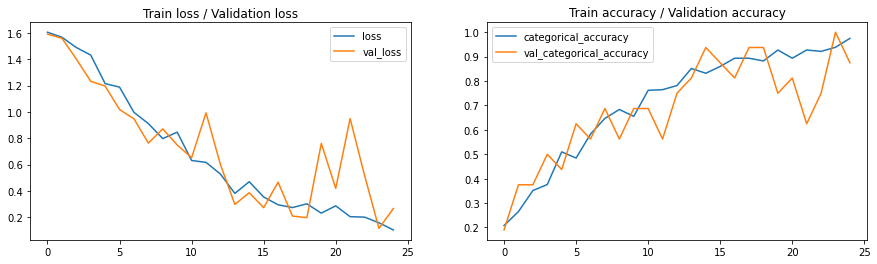

In [30]:
plotModelHistory(model13_history)

Reduced the filter size to 2 from 3 for Model8.Lower number of trainable parameters are noticed but difference between training and validation accuracies is high.

### Models by changing the architecture to conv2d , LSTM, GRU (RNN)

In [16]:
#LSTM with 128 lstm cells
model2d_1_batch_size=32
model2d_1_image_size=80

model2d_1 = Sequential()
model2d_1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(16,80,80,3)))
model2d_1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model2d_1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model2d_1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model2d_1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model2d_1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model2d_1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model2d_1.add(TimeDistributed(MaxPooling2D((2, 2))))

model2d_1.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model2d_1.add(TimeDistributed(MaxPooling2D((2, 2))))

model2d_1.add(TimeDistributed(Flatten()))

model2d_1.add(LSTM(128))
model2d_1.add(Dropout(0.2))
        
model2d_1.add(Dense(64,activation='relu'))
model2d_1.add(Dropout(0.2))
        
model2d_1.add(Dense(5, activation='softmax'))
              
optimiser = tf.optimizers.Adam()
model2d_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2d_1.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_33 (TimeDi  (None, 16, 80, 80, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 16, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 16, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 16, 20, 20, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 16, 20, 20, 64)  

In [17]:
model2d_1_history=model_train(model2d_1,model2d_1_batch_size,model2d_1_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6207 - categorical_accuracy: 0.1916Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.60056, saving model to model_init_2022-06-1013_40_18.792695/model-00001-1.62071-0.19155-1.60056-0.22000.h5
21/21 [==============================] - 85s 4s/step - loss: 1.6207 - categorical_accuracy: 0.1916 - val_loss: 1.6006 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.6066 - categorical_accuracy: 0.2195
Epoch 00002: val_loss did not improve from 1.60056
21/21 [==============================] - 52s 3s/step - loss: 1.6066 - categorical_accuracy: 0.2195 - val_loss: 1.6020 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.5933 - categorical_accuracy: 0.2670
Epoch 00003: va

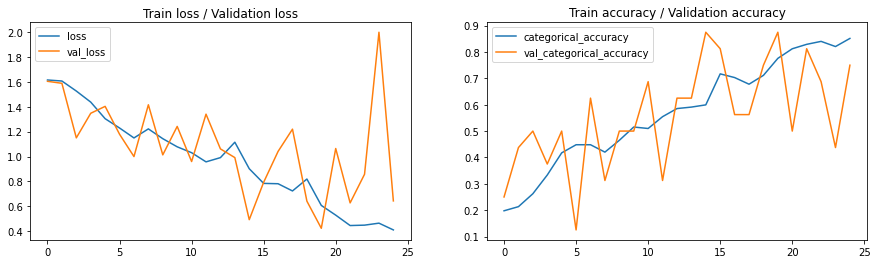

In [54]:
plotModelHistory(model2d_1_history)

Model is overfitting

In [21]:
#Model conv2d+ GRU

model2d_2_batch_size=32
model2d_2_image_size=80

model2d_2 = Sequential()
model2d_2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(16,80,80,3)))
model2d_2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model2d_2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model2d_2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model2d_2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model2d_2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model2d_2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model2d_2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model2d_2.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model2d_2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model2d_2.add(TimeDistributed(Flatten()))

model2d_2.add(GRU(128))
model2d_2.add(Dropout(0.2))
        
model2d_2.add(Dense(64,activation='relu'))
model2d_2.add(Dropout(0.2))
        
model2d_2.add(Dense(5, activation='softmax'))
              
optimiser = tf.optimizers.Adam()
model2d_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2d_2.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 16, 80, 80, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 16, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 16, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 16, 20, 20, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 16, 20, 20, 64)  

In [22]:
model2d_2_history=model_train(model2d_2,model2d_2_batch_size,model2d_2_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6113 - categorical_accuracy: 0.2142Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.59374, saving model to model_init_2022-06-1013_40_18.792695/model-00001-1.61126-0.21418-1.59374-0.41000.h5
21/21 [==============================] - 83s 4s/step - loss: 1.6113 - categorical_accuracy: 0.2142 - val_loss: 1.5937 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.5975 - categorical_accuracy: 0.2070
Epoch 00002: val_loss did not improve from 1.59374
21/21 [==============================] - 52s 3s/step - loss: 1.5975 - categorical_accuracy: 0.2070 - val_loss: 1.5952 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.5470 - categorical_accuracy: 0.2623
Epoch 00003: va

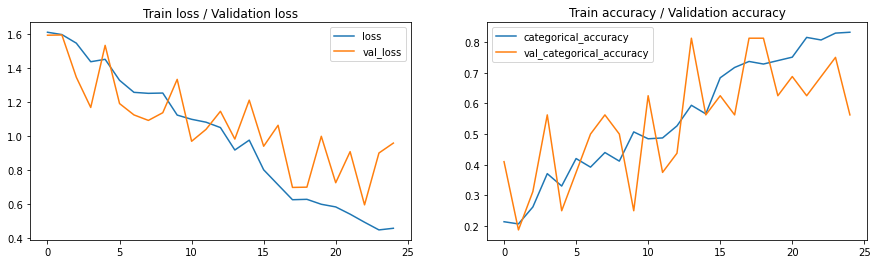

In [23]:
plotModelHistory(model2d_2_history)

Model is overfitting with GRU

In [18]:
model2d_3_batch_size=32
model2d_3_image_size=80

model2d_3 = Sequential()
model2d_3.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(16,80,80,3)))
model2d_3.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model2d_3.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model2d_3.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model2d_3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model2d_3.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model2d_3.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model2d_3.add(TimeDistributed(MaxPooling2D((2, 2))))

model2d_3.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model2d_3.add(TimeDistributed(MaxPooling2D((2, 2))))

model2d_3.add(TimeDistributed(Flatten()))

model2d_3.add(LSTM(128))
model2d_3.add(Dropout(0.2))
        
model2d_3.add(Dense(128,activation='relu'))
model2d_1.add(Dropout(0.2))
        
model2d_3.add(Dense(5, activation='softmax'))
              
optimiser = tf.optimizers.Adam()
model2d_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2d_3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_44 (TimeDi  (None, 16, 80, 80, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 16, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 16, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 16, 20, 20, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 16, 20, 20, 64)  

In [19]:
model2d_3_history=model_train(model2d_3,model2d_3_batch_size,model2d_3_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6175 - categorical_accuracy: 0.1931Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.59990, saving model to model_init_2022-06-1013_40_18.792695/model-00001-1.61753-0.19306-1.59990-0.27000.h5
21/21 [==============================] - 82s 4s/step - loss: 1.6175 - categorical_accuracy: 0.1931 - val_loss: 1.5999 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.6011 - categorical_accuracy: 0.2484
Epoch 00002: val_loss improved from 1.59990 to 1.46618, saving model to model_init_2022-06-1013_40_18.792695/model-00002-1.60113-0.24845-1.46618-0.37500.h5
21/21 [==============================] - 54s 3s/step - loss: 1.6011 - categorical_accuracy: 0.2484 - val_loss: 1.4662 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 3/25
21/21

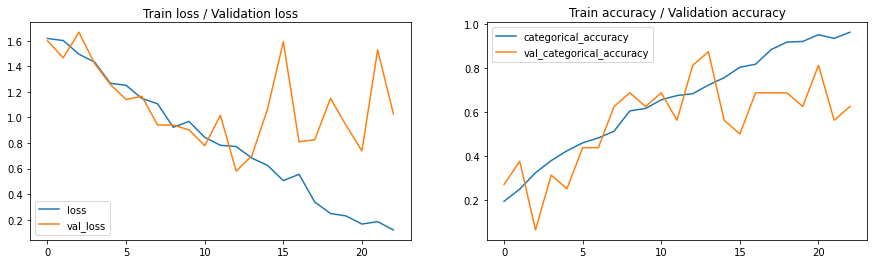

In [24]:
plotModelHistory(model2d_3_history)

### Using Transfer Learning MobileNet with GRU

In [26]:
from tensorflow.keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_tl_batch_size=32
model_tl_image_size=80

model_tl = Sequential()
model_tl.add(TimeDistributed(mobilenet_transfer, input_shape =(16,80,80,3)))
for layer in model_tl.layers:
    layer.trainable=False
model_tl.add(TimeDistributed(MaxPooling2D((2, 2))))
model_tl.add(TimeDistributed(Flatten()))

# GRU
model_tl.add(GRU(128, activation='relu'))
model_tl.add(Dropout(0.2))
# Output layer
model_tl.add(Dense(5, activation='softmax'))

optimiser = tf.optimizers.Adam()
model_tl.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_tl.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_78 (TimeDi  (None, 16, 2, 2, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_79 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_80 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_5 (GRU)                 (None, 128)               443136    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                      

In [27]:
model_tl_history=model_train(model_tl,model_tl_batch_size,model_tl_image_size)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 2.2364 - categorical_accuracy: 0.2986Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.25584, saving model to model_init_2022-06-1013_40_18.792695/model-00001-2.23640-0.29864-1.25584-0.49000.h5
21/21 [==============================] - 84s 4s/step - loss: 2.2364 - categorical_accuracy: 0.2986 - val_loss: 1.2558 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.1297 - categorical_accuracy: 0.5404
Epoch 00002: val_loss improved from 1.25584 to 1.10943, saving model to model_init_2022-06-1013_40_18.792695/model-00002-1.12968-0.54037-1.10943-0.50000.h5
21/21 [==============================] - 53s 3s/step - loss: 1.1297 - categorical_accuracy: 0.5404 - val_loss: 1.1094 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 3/25
21/21

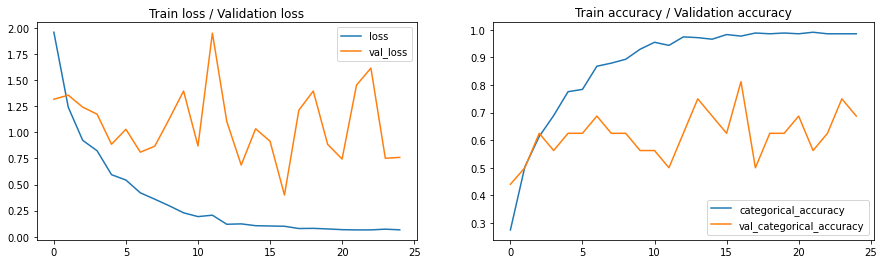

In [14]:
plotModelHistory(model_tl_history)

### Conclusion

We ran expermients based on the following

- Number of frames being passsed
- Batch size
- Image Size
- Filter Size
- Architecture
- Neuron counts and hidden layers

From all the above models noticed Model8 with following parameters is pretty good compared with other ones.

    Architecture - Conv3D and MaxPooling3D
    Batch Size - 32 
    Image Size - 80
    Filter size -3,3,3
    Frames passed - 16 (Alternate frames)
    Trainable Parameters - 501,189

    Training Accuracy - 93%
    Validation Accuracy - 93%

